# Práctica: análisis de opinión en críticas hoteleras

<img src="img/bellagio.jpg" style="width:200x;height:150;">

Vamos a poner en práctica todo lo aprendido hasta el momento sobre un problema de análisis de críticas a hoteles. El conjunto de datos que utilizaremos es una extracción de Booking.com, disponible en formato original en [Kaggle](https://www.kaggle.com/jiashenliu/515k-hotel-reviews-data-in-europe).

## Instrucciones

A lo largo de este cuaderno encontrarás celdas vacías que tendrás que rellenar con tu propio código. Sigue las instrucciones del cuaderno y presta especial atención a los siguientes iconos:

<table>
<tr><td width="80"><img src="img/question.png" style="width:auto;height:auto"></td><td style="text-align:left">Deberás responder a la pregunta indicada con el código o contestación que escribas en la celda inferior. Se te evaluará la práctica según la corrección de tu solución, así como por la calidad del código.</td></tr>
 <tr><td width="80"><img src="img/exclamation.png" style="width:auto;height:auto"></td><td style="text-align:left">Esto es una pista u observación que te puede ayudar a resolver la práctica. No tienes que escribir en el cuaderno ninguna contestación a estos apartados, pero conviene que los hagas para entender los siguientes pasos.</td></tr>
 <tr><td width="80"><img src="img/pro.png" style="width:auto;height:auto"></td><td style="text-align:left">Este es un ejercicio avanzado y voluntario que puedes realizar si quieres profundar más sobre el tema. No se considerará para la evaluación de la práctica, pero te animamos a intentarlo para aprender más ¡Ánimo!</td></tr>
</table>

Adicionalmente si necesitas consultar la ayuda de cualquier función python puedes colocar el cursor de escritura sobre el nombre de la misma y pulsar Mayúsculas+Shift para que aparezca un recuadro con sus detalles. Ten en cuenta que esto únicamente funciona en las celdas de código.

¡Adelante!

## Entorno

Para realizar la práctica, debes usar el **entorno de conda utilizado en las clases de deeplearning**. Para instalarlo:

    conda env create -f environment-deeplearning.yml deeplearning-labs 
    conda ativate deeplearning-labs

Después de instalarlo, **asegurate de tener el kernel de jupyter fijado con este entorno recién instalado**. 

*(opcional)* Si quieres usar paquetes adiccionales de pyhton que no estén instalados en este entorno conda, puedes instarlarlos una vez este esté activado con el siguiente comando:

    conda install PACKAGENAME
    
Si el paquete corresponde al respositorio de Anaconda. Si no deberás usar

    pip install PACKAGENAME
    
Si decides añadir nuevos paquetes, debes listarlos a continuación e indicar la versión del nuevo paquete utilizada en tu entorno. La versión instalada puedes verla ejecutando `conda list` y buscando el paquete entre todos los instalados en ese entorno activado.

* Package1: ...
* ...

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

## Objetivo: Aplica lo aprendido

El objetivo de la práctica es utilizar los datos de entrenamiento para construir un clasificador automático que indique si una crítica de un hotel es favorable o desfavorable. Puedes utilizar cualquiera de las técnicas vistas durante el curso para este fin, aunque a continuación se piden una serie mínima de estrategias a emplear. Para medir la calidad del modelo de clasificación, puedes utilizar el conjunto de datos de test, pero es importante remarcar que estos datos **solo pueden utilizarse para medir el acierto del clasificador**. Esto implica que tampoco pueden emplearse los datos de test para realizar técnicas de validación cruzada o entrenar vectorizadores de textos.

Este problema es desbalanceado, ya que existen muchos más datos de críticas positivas que de críticas negativas. Por ello, usar la precisión o accuracy como métrica de la calidad del modelo **no es aconsejable**, ya que un modelo que clasifique todas críticas como positivas obtendrá una precisión muy alta, a pesar de su falta de utilidad en práctica. En su lugar deberá emplearse la métrica [roc_auc_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html), que tiene en cuenta la importancia de ambas clases.

Para cada modelo, se deberá generar **la curva roc** y **elegir un threshold** adecuado con el cual poder ver **la matriz de confusión** para posteriormente poder comparar resultados entre todos los modelos realizados.

## Carga de datos

Para empezar vamos a cargar los datos de entrenamiento y test en memoria.

<table>
<tr><td width="80"><img src="img/question.png" style="width:auto;height:auto"></td><td style="text-align:left">Carga los datos de <b>data/train.csv</b> y <b>data/test.csv</b> en DataFrames de Pandas con nombres <b>train</b> y <b>test</b>, respectivamente.</td></tr>
</table>

In [3]:
!python3 -m spacy download en_core_web_sm

2022-11-21 18:46:46.827621: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-21 18:46:47.422186: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib/cuda/include:/usr/lib/cuda/lib64:
2022-11-21 18:46:47.422867: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib/cuda/include:/usr/lib/cuda/lib64:
2022-11-21 18:46:47.422893: W tensorflow/com

In [4]:
# Librerías usadas en el código

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.svm import LinearSVC
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import roc_auc_score, plot_roc_curve, roc_curve
import spacy
import os
from keras.models import Sequential
from keras.layers import Embedding, Dense, Activation, LSTM
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences 

In [5]:
import tensorflow as tf

print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [6]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

<table>
<tr><td width="80"><img src="img/pro.png" style="width:auto;height:auto"></td><td style="text-align:left">En <b>data/train.csv</b> solo se incluye una porción del conjunto de entrenamiento. Si quieres tratar de conseguir mayores niveles de acierto, puedes emplear el conjunto de entrenamiento completo disponible en <b>data/trainfull.csv</b>.</td></tr>
</table>

In [7]:
####### INSERT YOUR CODE HERE
trainfull = pd.read_csv('data/trainfull.csv')

## Exploración de datos

A continuación, explora los datos cargados previamente. Puedes ver el número de datos de cada clase, realizar gráficos comparando las columnas, ver si tenemos datos nulos...

In [8]:
####### INSERT YOUR CODE HERE
trainfull.head()

,Negative_Review,Positive_Review,Approves
0,I am so angry that i made this post available...,Only the park outside of the hotel was beauti...,False
1,My room was dirty and I was afraid to walk ba...,Great location in nice surroundings the bar a...,False
2,Apart from the price for the brekfast Everyth...,Good location Set in a lovely park friendly s...,True
3,Nothing all great,Rooms were stunningly decorated and really sp...,True
4,No Negative,This hotel is being renovated with great care...,True


In [9]:
test.head()

,Negative_Review,Positive_Review,Approves
0,No Negative,Breakfast was excellent Reception was very he...,True
1,Nothing,Big breakfast very big and comfortable room,True
2,No Negative,Superb as always,True
3,Would have like to stay longer will stay here...,Great brekkie catered for all 3 of us and gre...,True
4,No Negative,Everything,True


In [10]:
train.head()

,Negative_Review,Positive_Review,Approves
0,I am so angry that i made this post available...,Only the park outside of the hotel was beauti...,False
1,My room was dirty and I was afraid to walk ba...,Great location in nice surroundings the bar a...,False
2,Apart from the price for the brekfast Everyth...,Good location Set in a lovely park friendly s...,True
3,Nothing all great,Rooms were stunningly decorated and really sp...,True
4,No Negative,This hotel is being renovated with great care...,True


In [11]:
train.shape

(10000, 3)

In [12]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    np.set_printoptions(precision=2)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [13]:
def custom_plot_auc_roc(fpr, tpr, auc):
    #create ROC curve
    plt.plot(fpr,tpr, label="AUC="+str(auc))
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc=4)
    plt.show()

## Modelos
### Modelo basado en caracteres

<table>
<tr><td width="80"><img src="img/question.png" style="width:auto;height:auto"></td><td style="text-align:left">Construye un modelo de clasificación que en base a la crítica en texto de un hotel determine si esta es favorable o desfavorable, empleando únicamente características basadas en los caracteres del texto. Mide el nivel de acierto sobre el conjunto de test. ¿Qué nivel de precisión puedes alcanzar?</td></tr>
</table>

<table>
<tr><td width="80"><img src="img/exclamation.png" style="width:auto;height:auto"></td><td style="text-align:left">Ten en cuenta que cada crítica de hotel incluye dos campos de texto, <i>Negative_Review</i> y <i>Positive_Review</i>. Es recomendable que construyas un modelo que analice ambos textos para tomar la decisión. Puedes construir un Pipeline que tenga en cuenta ambas entradas de datos usando <a href=https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html>ColumnTransformer</a></td></tr>
</table>

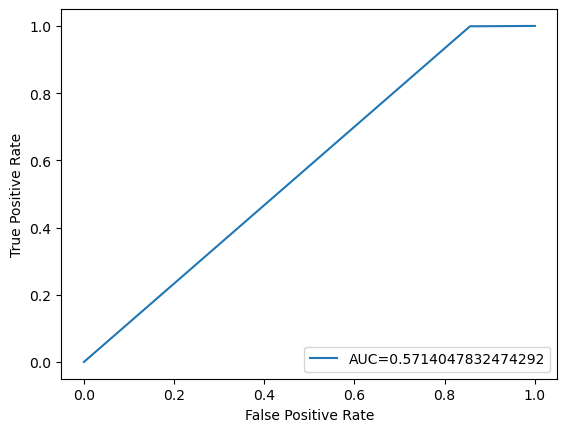

In [14]:
ct = ColumnTransformer(
    [
        ("vectorizer_negative", HashingVectorizer(ngram_range=(1,1), analyzer="char"), 'Negative_Review'),
        ("vectorizer_positive", HashingVectorizer(ngram_range=(1,1), analyzer="char"), 'Positive_Review'),
    ]
)

# La matriz obtenida tendrá por cada fila, los valores transformados de las dos reviews, creando un espacio de una única feature, que en realidad está representando ambas reviews.
# Ahora entrenamos el modelo vectorizador y transformamos los datos de train que van a pasar al modelo para entrenarlo.
ct.fit(train)
data_train_tr_char = ct.transform(train)

# Entrenamos el modelo, con los datos de train
model_char = LinearSVC()
model_char.fit(data_train_tr_char, train['Approves'])

# Ahora para poder saber como de bueno es nuestro modelo, pasamos los datos de test (transformados por nuestro vectorizador ya entrenado con los datos de train) al modelo para que prediga
data_test_tr_char = ct.transform(test)
y_pred_char =  model_char.predict(data_test_tr_char)

fpr, tpr, _ = roc_curve(test['Approves'], y_pred_char)
auc_char = roc_auc_score(test['Approves'], y_pred_char)

custom_plot_auc_roc(fpr, tpr, auc_char)

El score AUC-ROC del modelo es: 0.5714047832474292


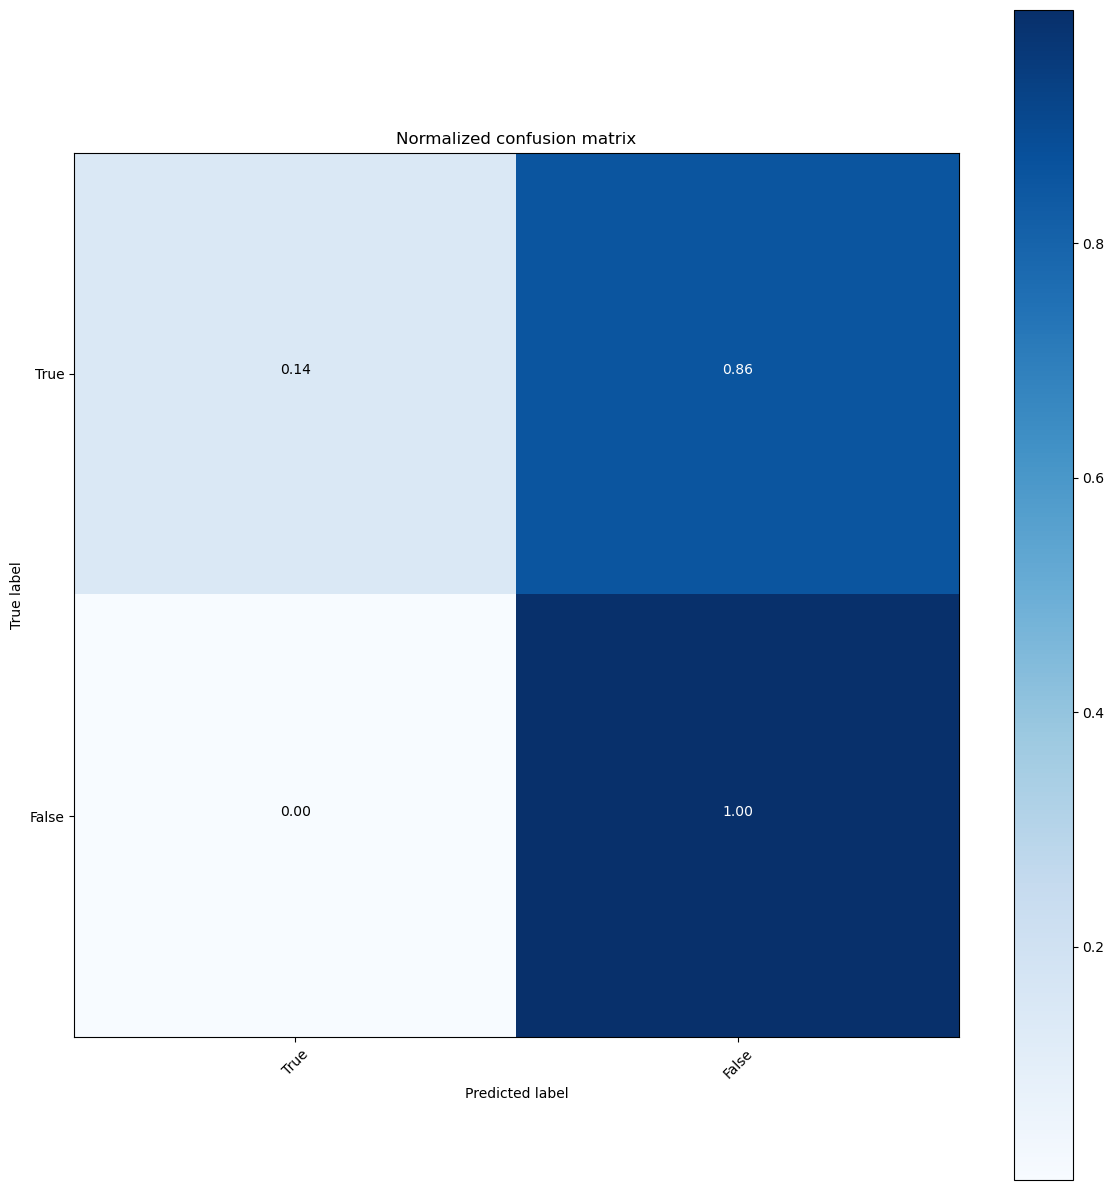

In [15]:
# De ahí sacamos la score roc_auc
print("El score AUC-ROC del modelo es:", roc_auc_score(test['Approves'], y_pred_char))

cnf_matrix = confusion_matrix(test['Approves'], y_pred_char)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=["True", "False"], normalize=True, title='Normalized confusion matrix')
plt.show()

### Modelo basado en tokens (palabras)

<table>
<tr><td width="80"><img src="img/question.png" style="width:auto;height:auto"></td><td style="text-align:left">Construye un modelo de clasificación que en base a la crítica en texto de un hotel determine si esta es favorable o desfavorable, empleando únicamente características basadas en los tokens del texto. Mide el nivel de acierto sobre el conjunto de test. ¿Qué nivel de precisión puedes alcanzar?</td></tr>
</table>

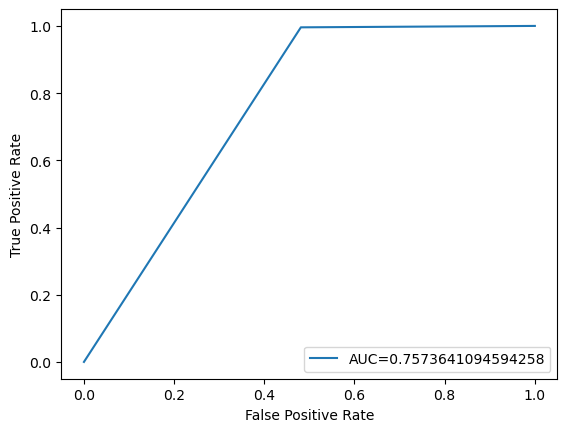

In [16]:
####### INSERT YOUR CODE HERE

ct = ColumnTransformer(
    [
        ("vectorizer_negative", HashingVectorizer(ngram_range=(1,1), analyzer="word"), 'Negative_Review'),
        ("vectorizer_positive", HashingVectorizer(ngram_range=(1,1), analyzer="word"), 'Positive_Review'),
    ]
)

ct.fit(train)
data_train_tr_token = ct.transform(train)

model_token = LinearSVC()
model_token.fit(data_train_tr_token, train['Approves'])

data_test_tr_token = ct.transform(test)
y_pred_token =  model_token.predict(data_test_tr_token)

fpr, tpr, _ = roc_curve(test['Approves'], y_pred_token)
auc_token = roc_auc_score(test['Approves'], y_pred_token)

custom_plot_auc_roc(fpr, tpr, auc_token)

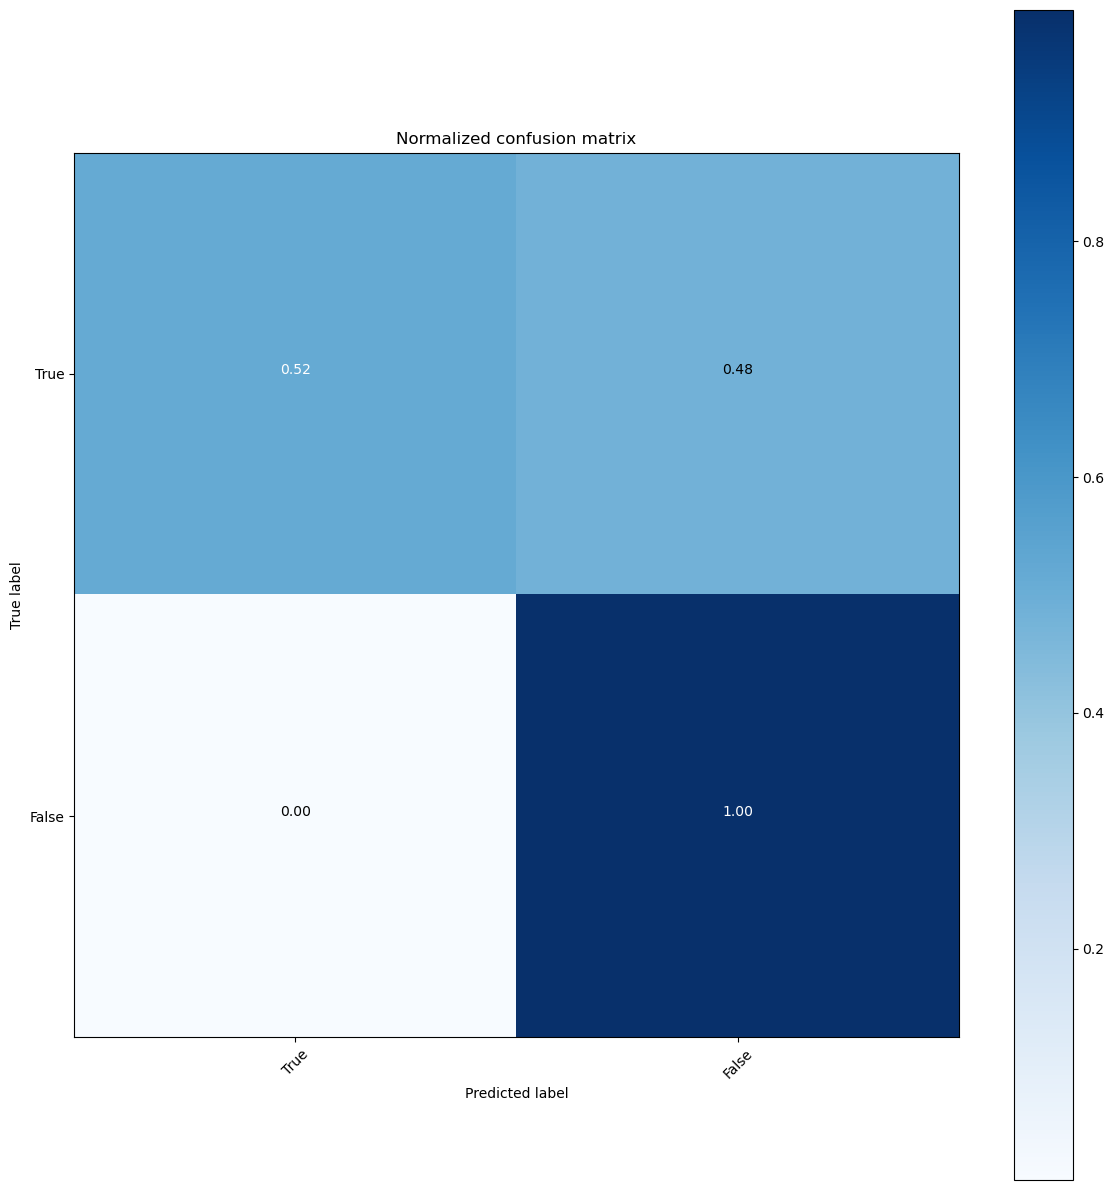

In [17]:
cnf_matrix = confusion_matrix(test['Approves'], y_pred_token)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=["True", "False"], normalize=True, title='Normalized confusion matrix')
plt.show()

### Modelo basado en análisis morfosintáctico

<table>
<tr><td width="80"><img src="img/question.png" style="width:auto;height:auto"></td><td style="text-align:left">Construye un modelo de clasificación que en base a la crítica en texto de un hotel determine si esta es favorable o desfavorable, empleando algún tipo de análisis morfosintáctico (como n-gramas de lemas, o filtros por POS o stopwords). Mide el nivel de acierto sobre el conjunto de test. ¿Qué nivel de precisión puedes alcanzar?</td></tr>
</table>

<table>
<tr><td width="80"><img src="img/exclamation.png" style="width:auto;height:auto"></td><td style="text-align:left">Recuerda que es posible acelerar el análisis morfosintáctico desactivando ciertas componentes del modelo nlp de spaCy. Revisa el notebook del ejercicio correspondiente para recordar cómo.</td></tr>
</table>

In [18]:
####### INSERT YOUR CODE HERE
nlp = spacy.load("en_core_web_sm", disable=['ner', 'parser'])

def token_morfosint_filter(df, fields):
    for field in fields:
        new_field = 'nlp_' + field
        df[new_field] = pd.Series([nlp(text) for text in df[field]], index=df.index)

        posfilter = [" ".join([token.lemma_ for token in text 
                                if token.pos_ in {"NOUN", "VERB", "ADJ", "ADV"} and not token.is_stop]) 
                        for text in df[new_field]]

        df['posfilter_' + field] = pd.Series(posfilter, index=df.index)


In [19]:
####### INSERT YOUR CODE HERE
token_morfosint_filter(train, train.columns[:2])
token_morfosint_filter(test, test.columns[:2])

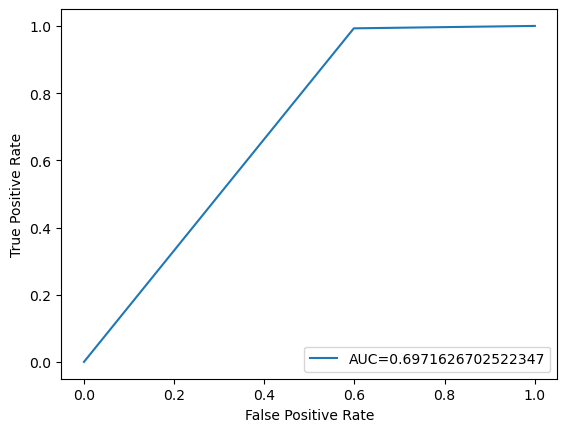

In [20]:
ct = ColumnTransformer(
    [
        ("vectorizer_negative", HashingVectorizer(ngram_range=(1,1), analyzer="word"), 'posfilter_Negative_Review'),
        ("vectorizer_positive", HashingVectorizer(ngram_range=(1,1), analyzer="word"), 'posfilter_Positive_Review'),
    ]
)

data_train_tr_morfo = ct.fit_transform(train)

model_morfo = LinearSVC()
model_morfo.fit(data_train_tr_morfo, train['Approves'])

data_test_tr_morfo = ct.transform(test)

y_pred_morfo =  model_morfo.predict(data_test_tr_morfo)

fpr, tpr, _ = roc_curve(test['Approves'], y_pred_morfo)
auc_morfo = roc_auc_score(test['Approves'], y_pred_morfo)

custom_plot_auc_roc(fpr, tpr, auc_morfo)

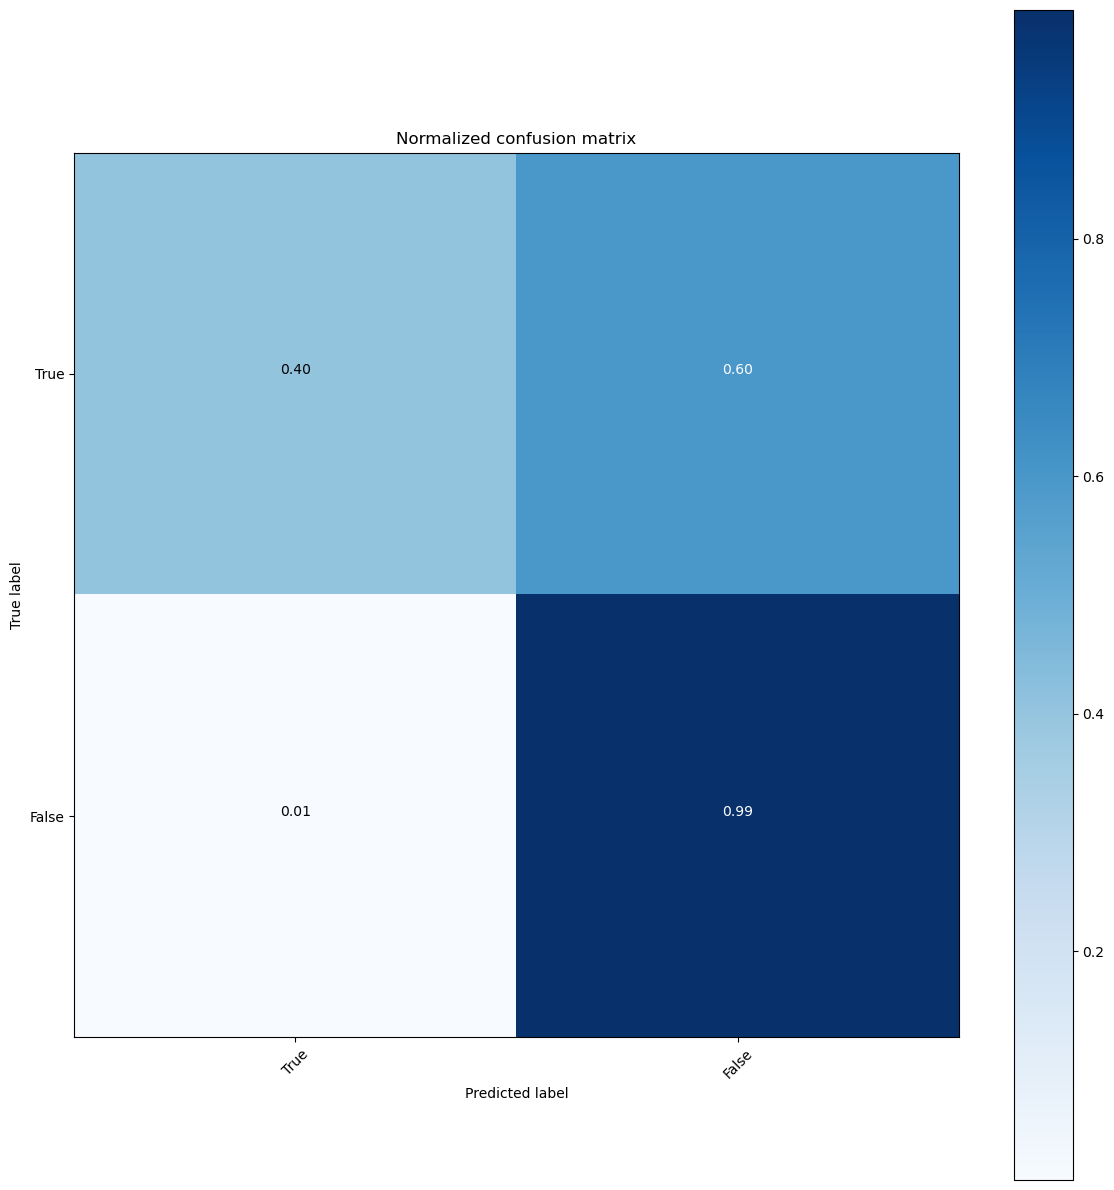

In [21]:
cnf_matrix = confusion_matrix(test['Approves'], y_pred_morfo)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=["True", "False"], normalize=True, title='Normalized confusion matrix')
plt.show()

### Modelo basado en Deep Learning

<table>
<tr><td width="80"><img src="img/question.png" style="width:auto;height:auto"></td><td style="text-align:left">Construye un modelo de clasificación que en base a la crítica en texto de un hotel determine si esta es favorable o desfavorable, empleando una aproximación basada en Embeddings y algún tipo de modelo de mezcla (CNN, LSTM, GRU, ...). Mide el nivel de acierto sobre el conjunto de test. ¿Qué nivel de precisión puedes alcanzar?</td></tr>
</table>

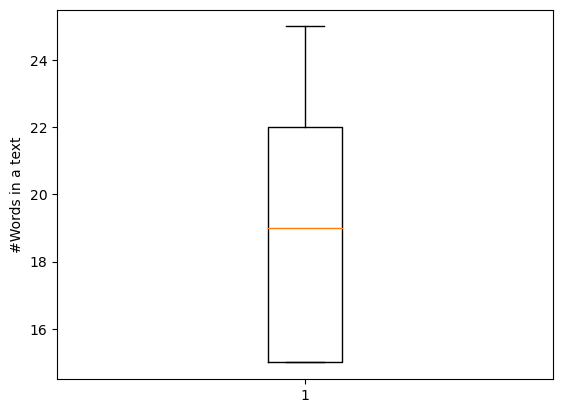

In [22]:
####### INSERT YOUR CODE HERE
os.environ['KMP_DUPLICATE_LIB_OK']='True'

plt.boxplot([len(text) for text in train], whis=[15, 85], showfliers=False)
plt.ylabel("#Words in a text")
plt.show()

In [23]:
train["posneg"] = train["Negative_Review"] + " " + train["Positive_Review"]
test["posneg"] = test["Negative_Review"] + " " + test["Positive_Review"]

In [24]:
maxwords = 15000
tokenizer = Tokenizer(num_words = maxwords)
tokenizer.fit_on_texts(train["posneg"])
X_train = tokenizer.texts_to_sequences(train["posneg"])
X_test = tokenizer.texts_to_sequences(test["posneg"])

# Vemos que como mucho, las frases tienen un total de 26 tokens, con esto no perderemos información
maxsequence = 26
X_train = pad_sequences(X_train, maxlen=maxsequence)
X_test = pad_sequences(X_test, maxlen=maxsequence)

In [ ]:
####### INSERT YOUR CODE HERE
model_dl = Sequential()
model_dl.add(Embedding(input_dim=maxwords, input_length=maxsequence, output_dim=64))
model_dl.add(LSTM(32))
model_dl.add(Dense(1))
model_dl.add(Activation('sigmoid'))

model_dl.compile(loss='binary_crossentropy', optimizer='adam', metrics=["accuracy"])
model_dl.summary()

model_dl.fit(X_train, train['Approves'], batch_size=32, epochs=2, validation_data=(X_test, test['Approves']))

y_pred_dl = model_dl.predict(X_test)
#plot_roc_curve(model_dl, X_test, test['Approves'])

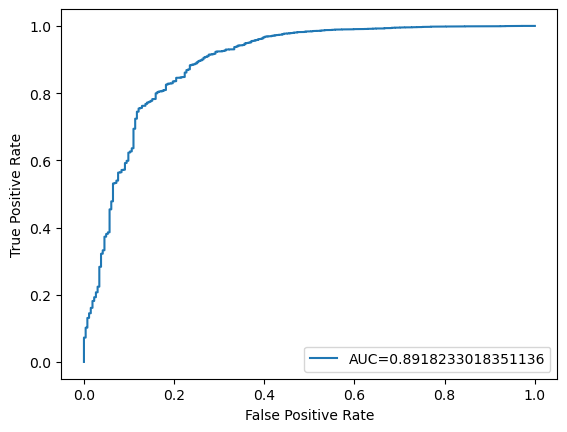

In [26]:
fpr, tpr, _ = roc_curve(test['Approves'], y_pred_dl)
auc_dl = roc_auc_score(test['Approves'], y_pred_dl)

custom_plot_auc_roc(fpr, tpr, auc_dl)

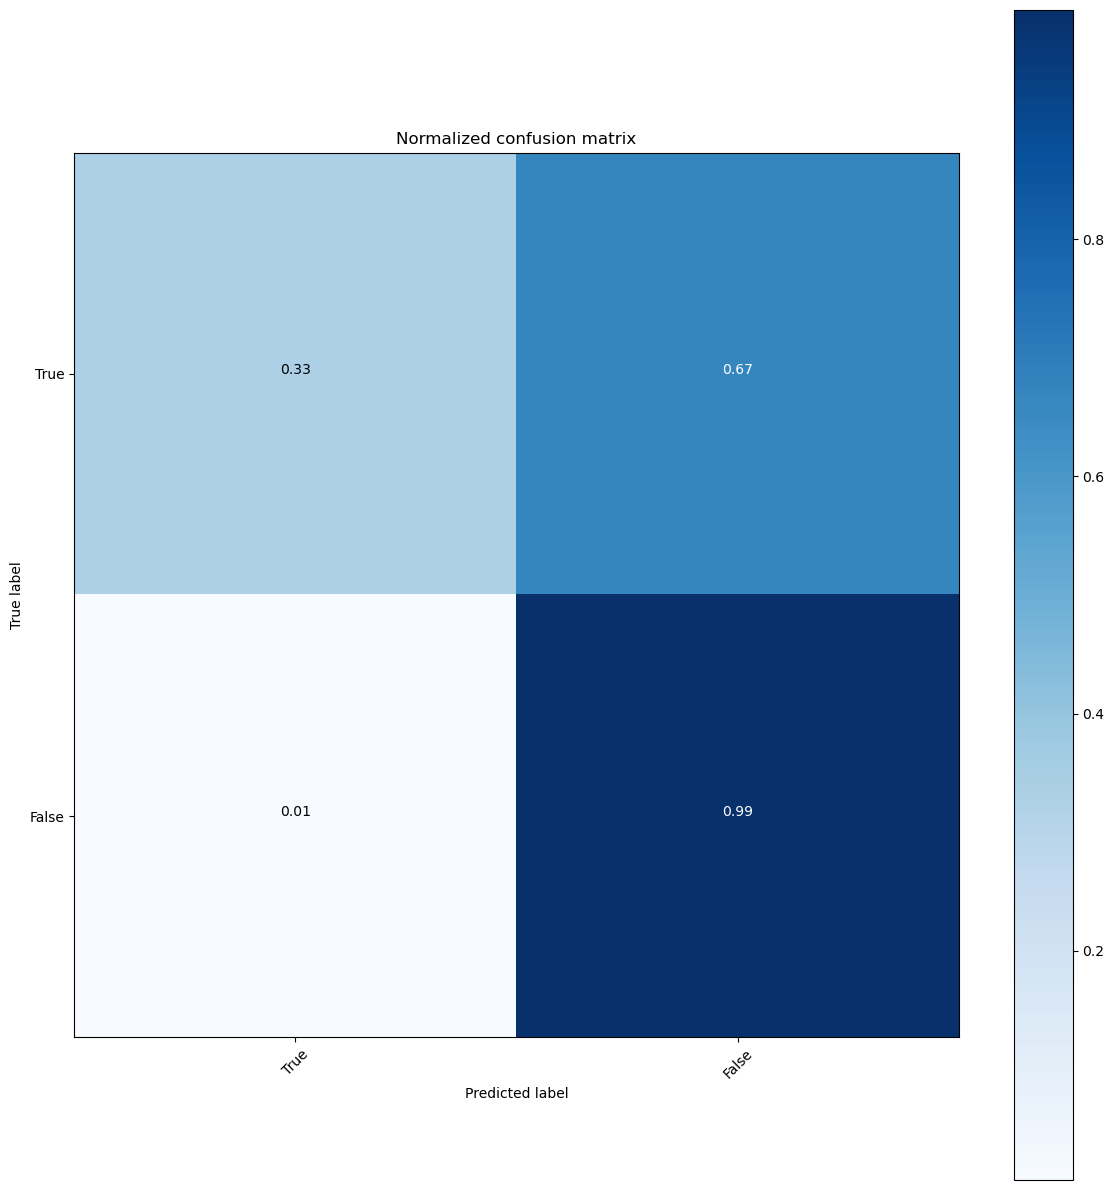

In [27]:
# Una red neuronal nos devuelve la probabilidad de que una instancia pertenezca (o no) a una clase, por lo que deberemos de transformar
# dichas probabilidades en las clases, en este caso tomando un umbral de 0.5
y_pred_bool = []

for pred in y_pred_dl:
    if pred >= 0.5:
        y_pred_bool.append(True)
    else:
        y_pred_bool.append(False)

cnf_matrix = confusion_matrix(test['Approves'], pd.Series(y_pred_bool))
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=["True", "False"], normalize=True, title='Normalized confusion matrix')
plt.show()

## Otras aproximaciones

<table>
<tr><td width="80"><img src="img/pro.png" style="width:auto;height:auto"></td><td style="text-align:left">Intenta mezclar varias de las features de puntos anteriores en un único modelo, o probar otras aproximaciones. ¿Puedes conseguir un acierto aún mejor?</td></tr>
</table>

In [28]:
####### INSERT YOUR CODE HERE
token_morfosint_filter(trainfull, trainfull.columns[:2])
token_morfosint_filter(test, test.columns[:2])

trainfull["posneg_filter"] = trainfull["posfilter_Negative_Review"] + " " + trainfull["posfilter_Positive_Review"]
test["posneg_filter"] = test["posfilter_Negative_Review"] + " " + test["posfilter_Positive_Review"]

In [29]:
maxwords = 50000
tokenizer = Tokenizer(num_words = maxwords)
tokenizer.fit_on_texts(trainfull["posneg_filter"])
X_train = tokenizer.texts_to_sequences(trainfull["posneg_filter"])
X_test = tokenizer.texts_to_sequences(test["posneg_filter"])

# Vemos que como mucho, las frases tienen un total de 26 tokens, con esto no perderemos información
maxsequence = 26
X_train = pad_sequences(X_train, maxlen=maxsequence)
X_test = pad_sequences(X_test, maxlen=maxsequence)

####### INSERT YOUR CODE HERE
model_dl = Sequential()
model_dl.add(Embedding(input_dim=maxwords, input_length=maxsequence, output_dim=64))
model_dl.add(LSTM(32))
model_dl.add(Dense(1))
model_dl.add(Activation('sigmoid'))

model_dl.compile(loss='binary_crossentropy', optimizer='adam', metrics=["accuracy"])
model_dl.summary()

model_dl.fit(X_train, trainfull['Approves'], batch_size=32, epochs=10, validation_data=(X_test, test['Approves']))

y_pred_dl = model_dl.predict(X_test)

print("AUC score", roc_auc_score(test['Approves'], y_pred_dl))

10515/10515 [==============================] - ETA: 0s - loss: 0.0276 - accuracy: 0.9919

2022-11-21 19:25:34.504147: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


10515/10515 [==============================] - 148s 14ms/step - loss: 0.0276 - accuracy: 0.9919 - val_loss: 0.0785 - val_accuracy: 0.9796
Epoch 8/10
 5474/10515 [==============>...............] - ETA: 1:12 - loss: 0.0244 - accuracy: 0.9930

2022-11-21 19:26:54.672733: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


10515/10515 [==============================] - 149s 14ms/step - loss: 0.0253 - accuracy: 0.9927 - val_loss: 0.0762 - val_accuracy: 0.9801
Epoch 9/10
  570/10515 [>.............................] - ETA: 2:15 - loss: 0.0207 - accuracy: 0.9942

2022-11-21 19:28:13.352456: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


 3478/10515 [========>.....................] - ETA: 1:34 - loss: 0.0217 - accuracy: 0.9941

2022-11-21 19:28:52.503581: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


 7041/10515 [===================>..........] - ETA: 45s - loss: 0.0222 - accuracy: 0.9938

2022-11-21 19:29:38.763442: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


10515/10515 [==============================] - ETA: 0s - loss: 0.0231 - accuracy: 0.9935

2022-11-21 19:30:24.091535: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


10515/10515 [==============================] - 140s 13ms/step - loss: 0.0231 - accuracy: 0.9935 - val_loss: 0.0858 - val_accuracy: 0.9784
Epoch 10/10
 6115/10515 [================>.............] - ETA: 57s - loss: 0.0209 - accuracy: 0.9941

2022-11-21 19:31:45.324810: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


 7806/10515 [=====================>........] - ETA: 35s - loss: 0.0207 - accuracy: 0.9941

2022-11-21 19:32:06.845959: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


 8657/10515 [=======================>......] - ETA: 24s - loss: 0.0210 - accuracy: 0.9941

2022-11-21 19:32:18.155932: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


10515/10515 [==============================] - ETA: 0s - loss: 0.0212 - accuracy: 0.9940

2022-11-21 19:32:42.837710: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


313/313 [==============================] - 1s 3ms/step
AUC score 0.9297728984587037


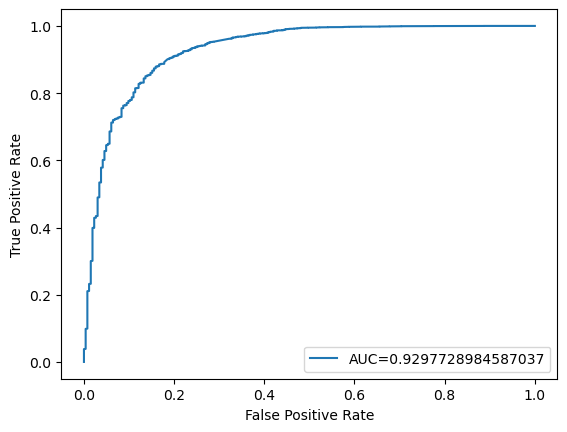

In [32]:
fpr, tpr, _ = roc_curve(test['Approves'], y_pred_dl)
auc_dl_impr = roc_auc_score(test['Approves'], y_pred_dl)
#create ROC curve
custom_plot_auc_roc(fpr, tpr, auc_dl_impr)

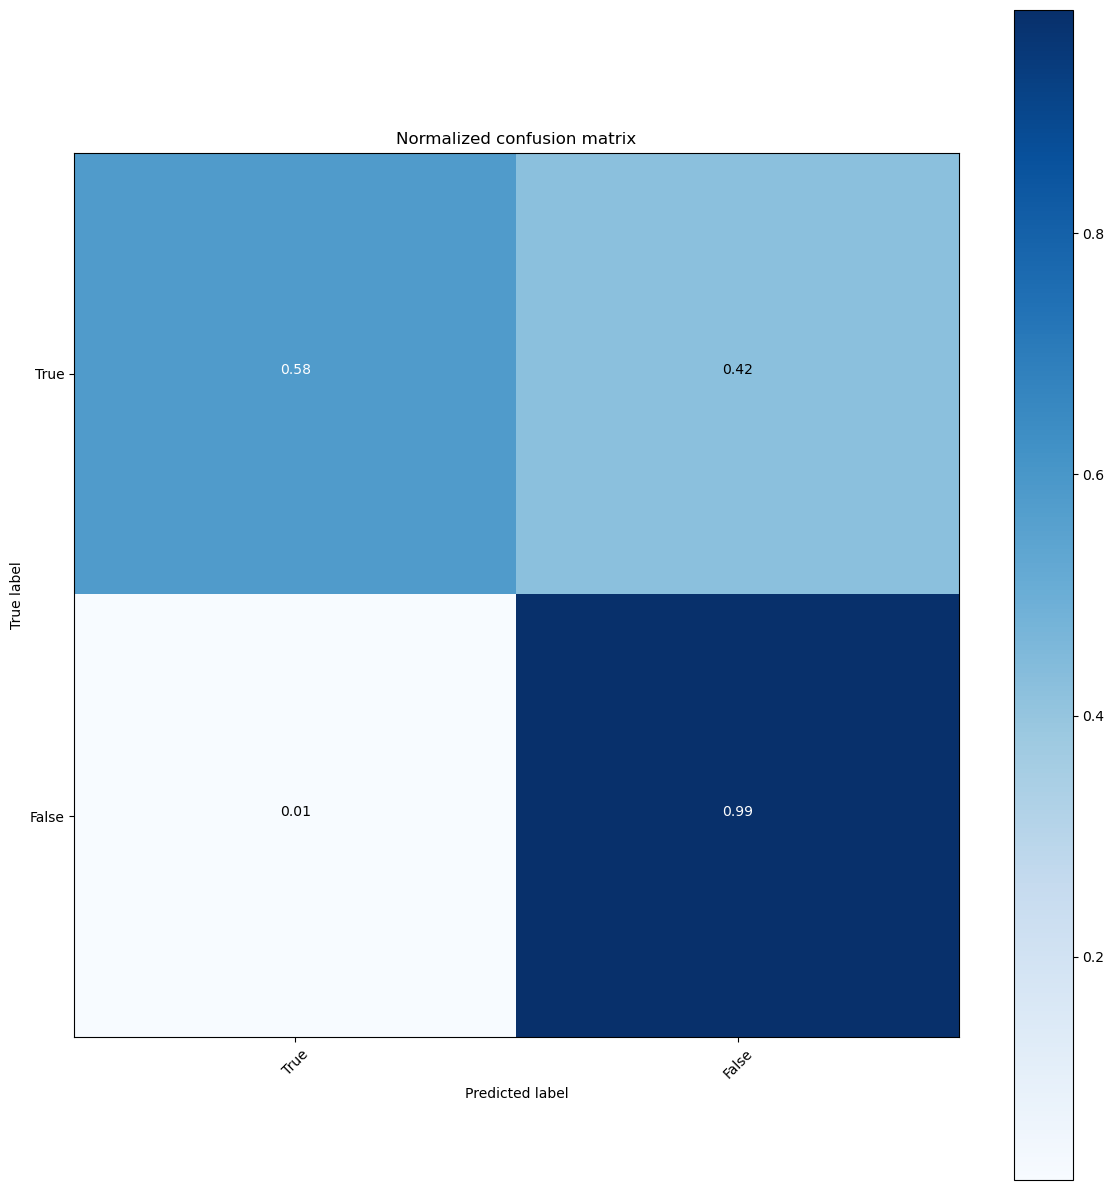

In [35]:
y_pred_bool = []

for pred in y_pred_dl:
    if pred >= 0.5:
        y_pred_bool.append(True)
    else:
        y_pred_bool.append(False)

cnf_matrix = confusion_matrix(test['Approves'], pd.Series(y_pred_bool))
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=["True", "False"], normalize=True, title='Normalized confusion matrix')
plt.show()

## Informe

<table>
<tr><td width="80"><img src="img/question.png" style="width:auto;height:auto"></td><td style="text-align:left">Escribe un informe explicando qué decisiones has tomado a la hora de diseñar el modelo, qué cosas has probado, qué ha funcionado y qué no. Además, realiza una tabla comparativa con los scores sobre el conjunto de test de todos los modelos realizados en la práctica indicando con cuál se ha conseguido mejores resultados.</td></tr>
</table>

#### **Introducción**

Para el problema planteado se han contado con 4 metodologías parecidas, basadas en los siguientes tipos de análisis:

* **Análisis de caracteres**
* **Análisis de tokens**
* **Análisis morfosintáctico**
* **Análisis con Deep Learning**
* **Mejor aproximación**

Explicaremos ahora, la metolodología que se ha seguido en cada uno de ellos y los resultados obtenidos.

La tabla comparativa de los scores es la siguiente:

|Análisis| Modelo | SCORE (AUC-ROC) |
| ------ | ------ | --------------- |
| Carácteres | HashingVectorizer(char) + LinearSVC| 0.5714 |
| Tokens | HashingVectorizer(word) + LinearSVC| 0.75736 |
| Morfosintáctico | HashingVectorizer(word) + spaCy + LinearSVC | 0.69716 |
| Deep Learning | Sequential LSTM net | 0.8868 |
| Mejor aproximación | Sequential LSTM net + spaCy + trainfull| 0.919222 |

#### **Análisis de carácteres**

Este modelo ha sido el peor que se ha encontrado, con una score de **0.5714** lo cierto es que es un modelo que no ha conseguido adaptarse correctamente a los datos. Hemos empezado primero, creando un ColumnTransformer, que prácticamente lo que realiza es una union de columnas, dejandola en una sola y aplicando el vectorizador que indiquemos. El vectorizar que se ha escogido ha sido HashiVectorizer, por su optimización en el uso de memoria y su rápidez.

Una vez que se transforman los datos, estos han sido pasados al modelo y mediante el uso de los scores auc_roc se ha obtenido un score sobre los resultados obtenidos en el método predict. Posteriormente hemos mostrado los resultados gracias a la curva ROC, mostrando la evolución que enfrenta el número de positivos verdaderos y falsos positivos.

#### **Análisis de tokens**

En este caso se ha realizado una metología similar a la del análisis de caracteres, con la excepción de que en la función del vectorizador, en el parámetro analysis, se ha intercambiado "char" por "word" realizando por tanto n_gramas de tokens (en este caso, palabras). El score aumenta notablemente, **0.75736**, lo que nos hace pensar que la tokenización por palabras funciona bastante mejor que por caracteres.

#### **Análisis morfosintáctico**

En el caso del análisis morfosintáctico, usaremos la librería de spaCy para poder analizar los documentos y extraer caracteristicas de su estructura interna. En este caso creamos unos nuevos campos sirviendonos de la librería que nos transforma todas las palabras de un documento a su lemma. Una vez que tenemos esos campos, generamos unos nuevos a partir de ellos, donde, valiéndonos de la tokenización de spaCy, filtraremos por aquellos token cuyo tipo sea _Adjetivo, Verbo, Adverbio o Sustantivo_. Esto hará (en teoría) que las palabras con mayor carga emocional sean las que se queden, facilitando la entrada al modelo.

Esto no ha ocurrido, al menos para este modelo. Revisando, vemos que el score baja a **0.69716**, lo que nos hace pensar que, en este caso, el analisis morfosintáctico no está funcionando como se esperaba.

#### **Análisis con Deep Learning**

En este análisis nos servimos de la librería Keras para crear redes neuronales profundas. Nuestra red tendrá varias capas:

1. __Tokenizer__: Aunque esta capa no está en el modelo, a nivel de código, si es cierto que es parte de la red, ya que sin la conversión a vectores de nuestros textos, la red no comprendería el input. Tokenizamos concretamente el texto concatenado de las reviews positivas y negativas, creando un único texto donde se tienen ambos sentimientos, similar a lo que hacíamos con la clase ColumnTransformer.

2. __Embedding__: Capa de incrustación. Como tal es la capa que da la importancia a cada una de las palabras que se encuentran en los documentos. Es una capa pre-entrenada que realiza un producto con los documentos de entrada transformados a vectores. Esto será de utilidad para las siguientes capas de la red.

3. __LSTM__: (Long-Short Term Memory) Es la capa que tiene las neuronas que aprenden del pasado, es decir, que tienen memoria. Las neuronas pueden decidir además que es aquello que quieren recordar, ya que en las entradas a las mismas, tienen parámetros que les indican como de importante es esa entrada a la hora de memorizarla. Si un dato de entrada es muy importante, este puede ser memorizado en todo momento. Esto hace que en textos donde se denota una mayor importancia a algunas palabras/tokens (importancia dada por la capa de Embedding), se centre en ellas, desestimando aquellas que no den tanta información sobre el documento

4. __Dense__: La capa Dense se encargará de reunir toda la información que ha sido computada por las neuronas de la capa previa y reduciendola a un único vector. 

5. __Activation__: Esta última capa es la que determina la activación de las neuronas de salida. Al poner Sigmoid, estamos indicando al modelo que la función de activación es la función Sigmoidal que, en caso de tener valores muy altos va a 1 y en caso de tener valores bajos a 0. Esto se puede entender como la probabilidad de que un documento pertenezca o no a una determinada clase. Dado que las salidas de las NN no son las clases, deberemos de transformar esa salida a las etiquetas para cada uno de los documentos. Esto se ha hecho para calcular la matriz de confusión, ya que esta no acepta valores continuos y no podía ser representada.

El score para este modelo ha sido el mejor encontrado hasta el momento, con un **0.8868** que le hace estar bastante por delante del resto de modelos probados hasta el momento.

#### **Mejor aproximación**

Por último, vamos a coger lo mejor que hemos probado en cada uno de los modelos y juntarlo en un único modelo que, esperemos, sea el que mejor score nos dé de todos. Este modelo será de nuevo una red neuronal como la previa, pero introduciremos modificaciones tanto en el preprocesamiento como en el entrenamiento de la misma. Para empezar, todas las pruebas realizadas sobre los modelos, han sido hechas sobre los datos train, que es una versión reducida de los datos reales, trainfull. Ahora realizaremos de nuevo, la transformación de estos datos, concatenando el contenido de las reviews positivas y negativas y analizaremos sintácticamente todos y cada uno de los nuevos documentos concatenados, extrayendo de ellos adjetivos, verbos, adverbios y sustantivos. Posteriormente será pasada a la red, a la que le aumentaremos el número de epocas de 2 a 10. Entrenamos el modelo y se obtiene un score de **0.919222**. Siendo el modelo de todos los probados con el mejor score de todos. 
